## Is Volatility in Fed Sentiment a Useful Signal?
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

### Abstract

We try to measure the volatility in the sentiment of the Federal Reserve Bank, and try to find relationships between this volatility and the volatility of some macro-tracking ETFs.

### Introduction

We explore the [Prattle](http://prattle.co/) Central Bank Sentiment Dataset: this dataset contains weekly *sentiment data* from the Federal Reserve Bank. The sentiment data wraps up all publications of the Fed from every week (between about 1998 and 2015) into a single real number representing the general sentiment of the Fed that week.

We use standard deviation to create a volatility metric for this Fed Sentiment. We then try to find a relationship between the sentiment volatility over time and the volatility over time of the following ETFs:
- SPY
- DIA
- GLD
- TLT

We chose these ETFs in particular due to a [previous investigation](https://www.quantopian.com/posts/does-federal-reserve-sentiment-predict-prices-of-macro-tracking-etfs), to which this notebook is a follow-up. Though this notebook is a stand-alone, it may be beneficial to also read the previous notebook.

In [1]:
# Import libraries we will use
from matplotlib import pyplot
import datetime
import time
from pykalman import KalmanFilter
import numpy
import scipy
import pandas
import math

In [2]:
# grab the prattle dataset
prattle_data = local_csv('prattle.csv')
# filter to data from the fed only
fed_data = prattle_data[prattle_data.bank=='frc']

In [3]:
# helper functions

def convert_date(mydate):
    # converts string representing date to datetime object
    return datetime.datetime.strptime(mydate, "%Y-%m-%d")

# for grabbing dates and prices for a relevant equity
def get_data(etf_name,trading_start,trading_end='2015-07-20'):
    # using today as a default arg: assuming most of the ETFs I want to inspect
    # are still trading.
    stock_data = get_pricing(etf_name,
                        start_date = trading_start,
                        end_date = trading_end,
                        fields = ['close_price'],
                        frequency = 'daily')
    stock_data['date'] = stock_data.index
    # drop nans. For whatever reason, nans were causing the kf to return a nan array.
    stock_data = stock_data.dropna()
    # the dates are just those on which the prices were recorded
    dates = stock_data['date']
    dates = [convert_date(str(x)[:10]) for x in dates]
    prices = stock_data['close_price']
    return dates, prices

# for grabbing the prattle data on which the etf has been trading.
def get_prattle(trading_start,trading_end='2015-07-20'):
    # filter down to the relevant time period
    data_prattle = fed_data[fed_data.date > trading_start]
    data_prattle = data_prattle[trading_end > data_prattle.date]
    dates_prattle = data_prattle['date']
    dates_prattle = [convert_date(str(x)[:10]) for x in dates_prattle]
    scores_prattle = data_prattle['score']
    return dates_prattle, scores_prattle

In [4]:
# Initialize a Kalman Filter.
# Using kf to filter does not change the values of kf, so we don't need to ever reinitialize it.
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

The difficult question is: how do we construct the volatility metric for the Fed data? We pick an easy and plausible solution: just like we construct [volatility for equities](http://bit.ly/1HVMNhi).

We pick a particular timespan over which we wish to calculate volatility -- $d$ days -- and compute the standard deviation of the fed sentiment scores in that timespan, then divide by $d$. This lets us create a rolling measure of volatility. But first, let's look at the data.

In [5]:
# Look at the Fed Data since 1999-01-01.
dates_fed_1999, scores_fed_1999 = get_prattle('1999-01-01')

We plot the data and its Kalman-filtered moving average on it, just to get a feel for it as we move forward.

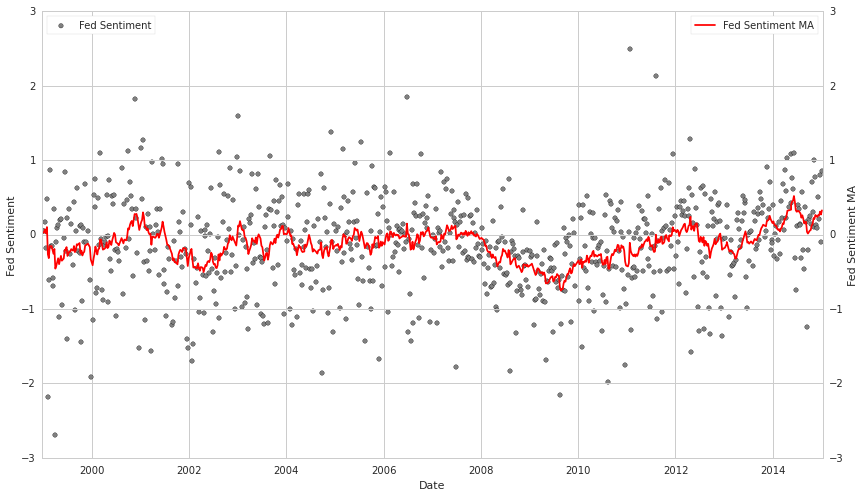

In [7]:
# Filter Rolling Means
scores_fed_1999_means, _ = kf.filter(scores_fed_1999.values)

# Overlay Plots
fig, ax1 = pyplot.subplots()
# Use a scatterplot instead of a line plot because a line plot would be far too noisy.
ax1.scatter(dates_fed_1999,scores_fed_1999,c='gray',label='Fed Sentiment')
pyplot.xlabel('Date')
pyplot.ylabel('Fed Sentiment')
pyplot.ylim([-3,3])
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_fed_1999,scores_fed_1999_means, c='red', label='Fed Sentiment MA')
pyplot.ylabel('Fed Sentiment MA')
pyplot.ylim([-3,3])
pyplot.legend(loc=1)

pyplot.show()

As we can see, the plot is quite noisy. There is a significant spread about the mean. Remarkably, the least spread appears to be around late 2007/early 2008. Though that's hardly information we can act on, it is historically interesting.

Anyway, we proceed to calculate rolling volatility. We'll test some different volatility windows. Note that since we only have weekly data, we have to use a somewhat long window anyway, just to get a useful sample size.

In [8]:
def roll_volatility(timeseries,n):
    # skip the first n/7 datapoints, since we're looking back over n days.
    skip = int(round(n/7)+1)
    out = [None]*skip
    sk = skip+1
    for i in range(sk,len(timeseries)+1):
        sub_series = timeseries[i-sk:i]
        std = numpy.std(sub_series)
        out.append(std)
    return out

In [9]:
fed_vol_1999_90 = roll_volatility(scores_fed_1999,90)
fed_vol_1999_180 = roll_volatility(scores_fed_1999,180)

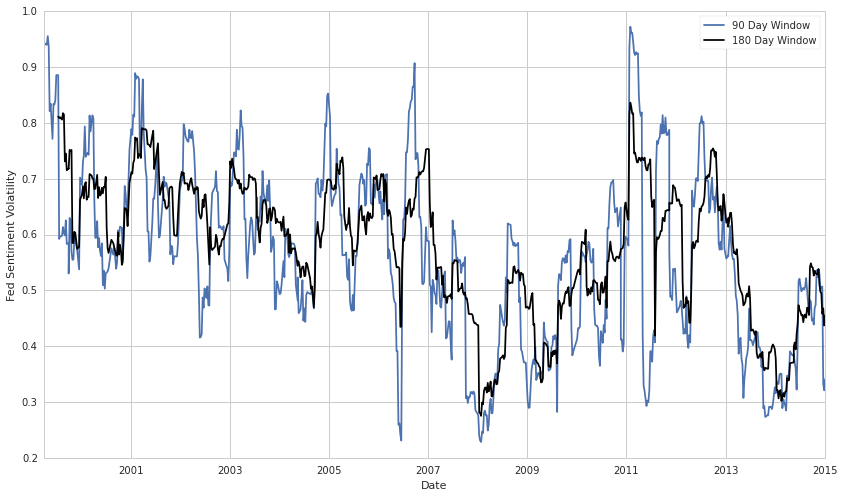

In [10]:
# let's plot it!
pyplot.plot(dates_fed_1999,fed_vol_1999_90,label='90 Day Window')
pyplot.plot(dates_fed_1999,fed_vol_1999_180,c='black',label='180 Day Window')
pyplot.xlabel('Date')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.legend()
pyplot.show()

We should take a moment to think about what the volatility in sentiment actually *means*. A high volatility over some window implies great variance in the weekly sentiments (i.e. a large spread of positive and negative sentiments). Low volatility implies homogeneity in weekly sentiments during that period.

We single out some periods for comment:
- The period encompassing late 2007/early 2008 has exceptionally low volatility. It follows that sentiment at the fed was quite homogeneous, in light of the overarching economic crisis. (Though, curiously, if we look at the scatterplot from the earlier section, we see that the sentiment at that time was not particularly negative.) 
- Another low-volatility period was around late 2013/early 2014. This may be due to the almost overwhelmingly bullish outlook on the economy at the time, which is also reflected in the scatterplot, which shows that the Fed sentiment sustained a significant high for that period.

Next, we'll try to see whether the sentiment volatility for these windows corresponds to price volatilities of our four ETFs. In the [last notebook](https://www.quantopian.com/posts/does-federal-reserve-sentiment-predict-prices-of-macro-tracking-etfs) we found that SPY and DIA both correspond strongly to Fed sentiment, whereas GLD probably doesn't (i.e. that relationship is obscured by other macroeconomic factors and international trade), and TLT seems to have a weak correspondence.

### SPY

With a market cap of \$177bn, SPY is one of the largest ETFs, tracking the Standard & Poor's 500 Index. Since our pricing dataset starts in 2002, we'll consider SPY's movements since `2002-03-03`.

In [11]:
# grab the SPY dataset and Kalman-filter it
dates_spy, prices_spy = get_data('SPY', '2002-03-03')
prices_spy_means, _ = kf.filter(prices_spy.values)

Now we calculate some rolling volatilities using different windows for SPY, and plot that. Note: we could've used VIX for this purpose, which tracks the volatility of SPY. It didn't occur to me at the time.

In [12]:
# First, we need some helper functions.

def add_days(s,x):
    """ takes a date in string format and adds exactly n days to it"""
    end = convert_date(s) + datetime.timedelta(days=x)
    return end.strftime('%Y-%m-%d')

def compute_volatility(opens,closes):
    """ calculates volatility as per 
        https://en.wikipedia.org/wiki/Volatility_(finance)#Mathematical_definition """
    # first: calculate the daily logarithmic rate of return
    daily_log_returns = [math.log(opens[x]/closes[x]) for x in range(len(opens))]
    # then get the standard deviation
    sigma_period = numpy.std(daily_log_returns)
    # now adjust to time period
    volatility = sigma_period / math.sqrt(len(opens))
    return volatility

def get_volatility(stock,n,today):
    """grabs the volatility over timespan of n days"""
    stock_data = get_pricing(stock, 
                             start_date = add_days(today, -n), 
                             end_date = today,
                             fields = ['open_price', 'close_price'],
                             frequency = 'daily')
    volatility = compute_volatility(stock_data.open_price, stock_data.close_price)
    return volatility
    
def etf_rolling_volatility(stock,n,dates,start_date):
    out = []
    nthday = convert_date(start_date)+ datetime.timedelta(days=n)
    for index,day in enumerate(list(dates)):
        # skip first n datapoints
        if day + datetime.timedelta(days=-1) < nthday:
            out.append(None)
        else:
            # adding days again is kind of an ugly (inefficient) solution
            dd = add_days(start_date,index)
            vol = get_volatility(stock,n,dd)
            out.append(vol)
    return out

In [13]:
# calculate the rolling volatilities for SPY
spy_vol_90 = etf_rolling_volatility('SPY',90,dates_spy,'2002-03-03')
spy_vol_180 = etf_rolling_volatility('SPY',180,dates_spy,'2002-03-03')

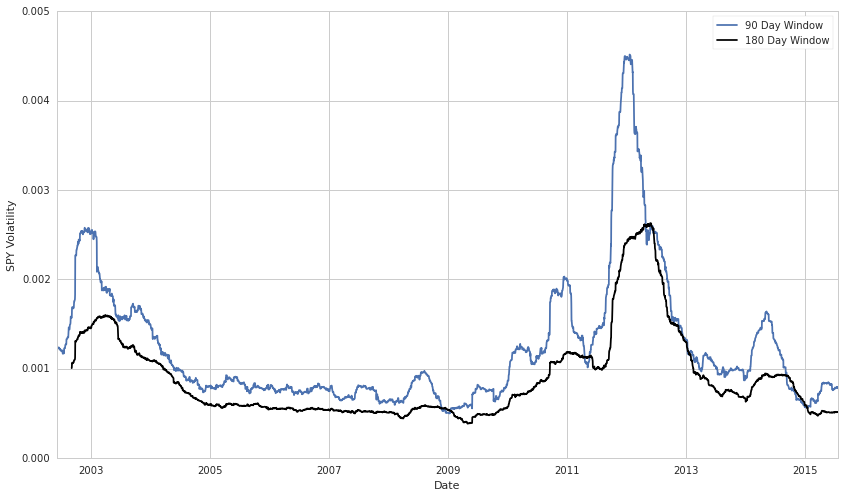

In [14]:
# let's plot it!
pyplot.plot(dates_spy,spy_vol_90,label='90 Day Window')
pyplot.plot(dates_spy,spy_vol_180,c='black',label='180 Day Window')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Volatility')
pyplot.legend()
pyplot.show()

We see the biggest spikes in volatility in late 2002 and in 2012. This is commensurate with [news at the time](http://www.bloomberg.com/news/articles/2012-07-02/volatility-surging-in-s-p-500-with-volume-lowest-in-decade-1-). 

Now we want to overlay the SPY volatility plot and the Fed sentiment volatility plot. We'll do this separately for each window.

In [15]:
# first: get data for the right time period
dates_fed_2002, scores_fed_2002 = get_prattle('2002-03-03')

fed_vol_2002_90 = roll_volatility(scores_fed_2002,90)
fed_vol_2002_180 = roll_volatility(scores_fed_2002,180)

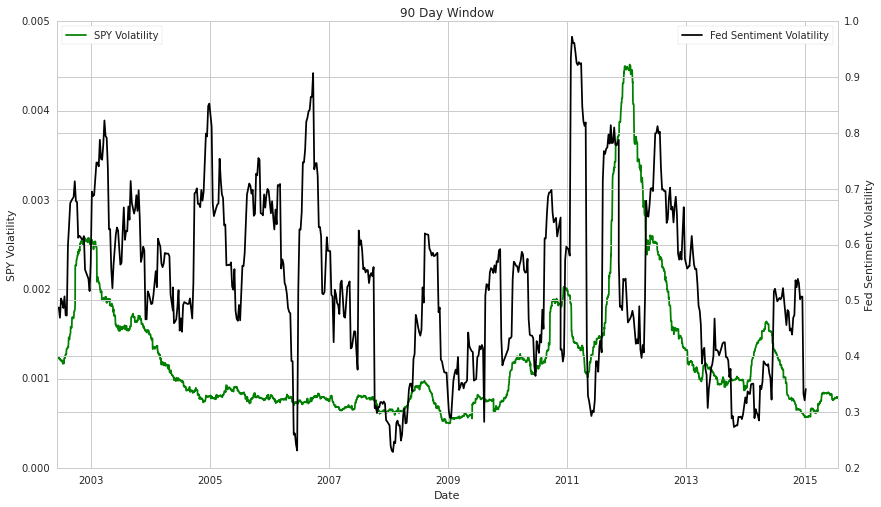

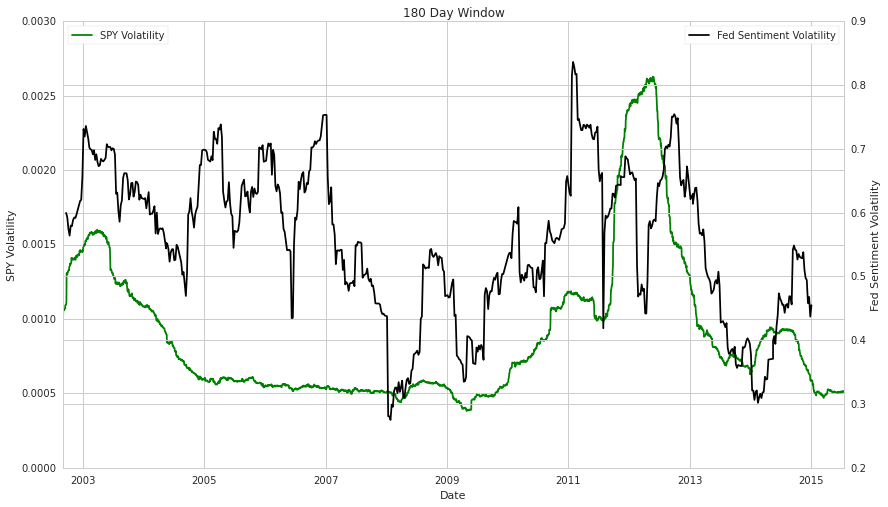

In [16]:
fig, ax1 = pyplot.subplots()
ax1.plot(dates_spy,spy_vol_90, c='green',label='SPY Volatility')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_fed_2002, fed_vol_2002_90, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('90 Day Window')
pyplot.legend(loc=1)

pyplot.show()

fig, ax1 = pyplot.subplots()
ax1.plot(dates_spy,spy_vol_180, c='green',label='SPY Volatility')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_fed_2002, fed_vol_2002_180, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('180 Day Window')
pyplot.legend(loc=1)

pyplot.show()

Visually, this is quite messy and it's hard to say if there is a relationship here. Looking at the 180 day window in particular,  it looks as though there might be an inverse relationship: when Fed sentiment volatility is high, SPY volatility is low, and vice-versa. We can test this proposition with [Spearman's Rho](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). 

In [17]:
# First, we've got to reduce SPY from weekly to daily.
# The fed measurement is always taken on a sunday, so matching up the two datasets exactly 
# is somewhat laborious. We'll just take every 5th datapoint from SPY so we get one datapoint per week.

spy_vol_90_weekly = spy_vol_90[::5]
dates_spy_weekly = dates_spy[::5]

spy_vol_180_weekly = spy_vol_180[::5]

To check that this reduction worked and did not lose important data (at least not such that it is visually apparent), you may choose to plot this "reduced" dataset, similar to how we plotted the overlays above. I did check this, but have chosen to omit the overlaid plots in the interest of space.

In [21]:
# Noting that the Fed dataset ends in January 2015, the spy_vol_x_weekly dataset has length 674 and
# the fed_vol_x_02 dataset has length 637. We truncate the spy_vol dataset at the end.

compare_spy_90 = spy_vol_90_weekly[:637]
compare_spy_180 = spy_vol_180_weekly[:637]

print scipy.stats.spearmanr(compare_spy_90,fed_vol_2002_90)
print scipy.stats.spearmanr(compare_spy_180,fed_vol_2002_180)
# printouts are in form (correlation coefficient, p-value)

(0.38238023710651281, 1.309800671281735e-23)
(0.54066701956840457, 1.2270971455379016e-49)


Interestingly, these numerical results show significant positive correlations. It is possible that there's a signal here. Intuitvely, this makes sense: we found in the [previous notebook](https://www.quantopian.com/posts/does-federal-reserve-sentiment-predict-prices-of-macro-tracking-etfs) that SPY and Fed Sentiment correlated very strongly visually. It is reassuring that we now find a significant correlation among their volatilities -- this strengthens our conclusion that SPY and Fed Sentiment share a strong relationship.



### DIA

Next, we look at **DIA**, which tracks the Dow Jones Industrial Average. DIA stores about \$11bn in assets. DIA started trading on `1998-01-20`. Since we have data only from 2002 onwards, we'll start our investigation at `2002-03-03`.

Before doing anything else, we'll check the correspondence between DIA and SPY.

In [20]:
# grab the DIA dataset.
dates_dia, prices_dia = get_data('DIA', '2002-03-03')
dia_vol_90 = etf_rolling_volatility('DIA',90,dates_dia,'2002-03-03')

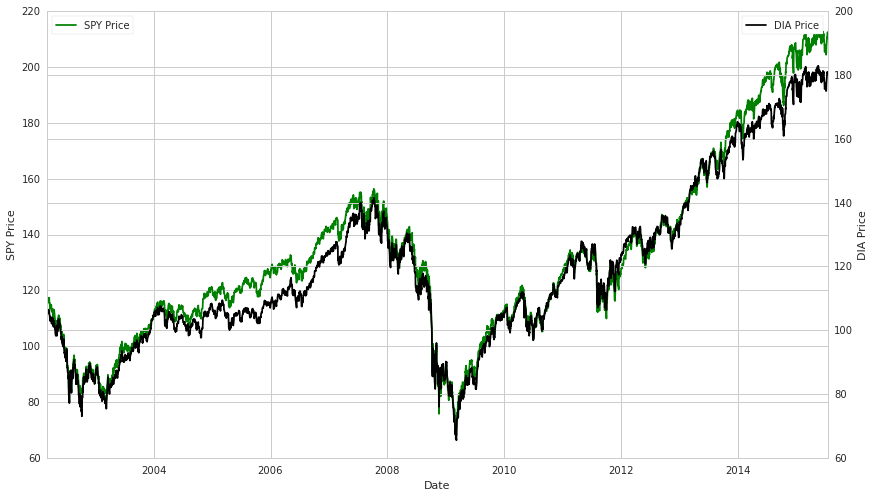

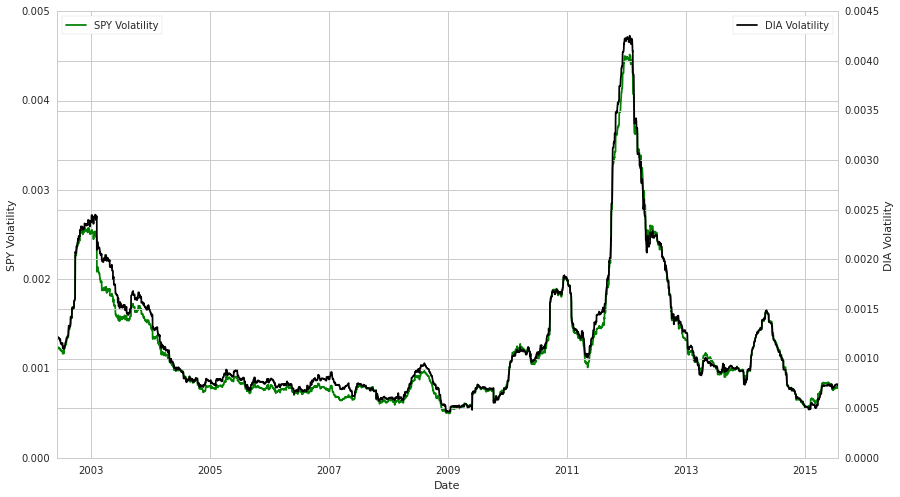

In [22]:
# Overlay Plots
fig, ax1 = pyplot.subplots()
ax1.plot(dates_spy,prices_spy, c='green',label='SPY Price')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Price')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_dia, prices_dia, c='black', label='DIA Price')
pyplot.ylabel('DIA Price')
pyplot.legend(loc=1)

pyplot.show()

fig, ax1 = pyplot.subplots()
ax1.plot(dates_spy,spy_vol_90, c='green',label='SPY Volatility')
pyplot.xlabel('Date')
pyplot.ylabel('SPY Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_dia, dia_vol_90, c='black', label='DIA Volatility')
pyplot.ylabel('DIA Volatility')
pyplot.legend(loc=1)

pyplot.show()

It is clearly apparent that DIA and SPY correlate extremely strongly, both in price and in their volatilities. Thus, trying to relate DIA and Fed Sentiment will have almost the exact same results as trying to relate SPY and Fed Sentiment. We can therefore skip this part of the investigation.

## GLD

We look at **GLD**, the largest gold ETF, storing assets of about \$24bn. GLD started trading on `2004-11-18`.

In [23]:
# grab the GLD dataset and relevant prattle data.
dates_gld, prices_gld = get_data('GLD', '2004-11-18')
dates_gld_prattle, scores_gld_prattle = get_prattle('2004-11-18')

In [24]:
# Fed sentiment volatility for the relevant time period
gld_prattle_vol_90 = roll_volatility(scores_gld_prattle,90)
gld_prattle_vol_180 = roll_volatility(scores_gld_prattle,180)

In [25]:
# Gold volatility for the relevant time period
gld_vol_90 = etf_rolling_volatility('GLD',90,dates_gld,'2004-11-18')
gld_vol_180 = etf_rolling_volatility('GLD',180,dates_gld,'2004-11-18')

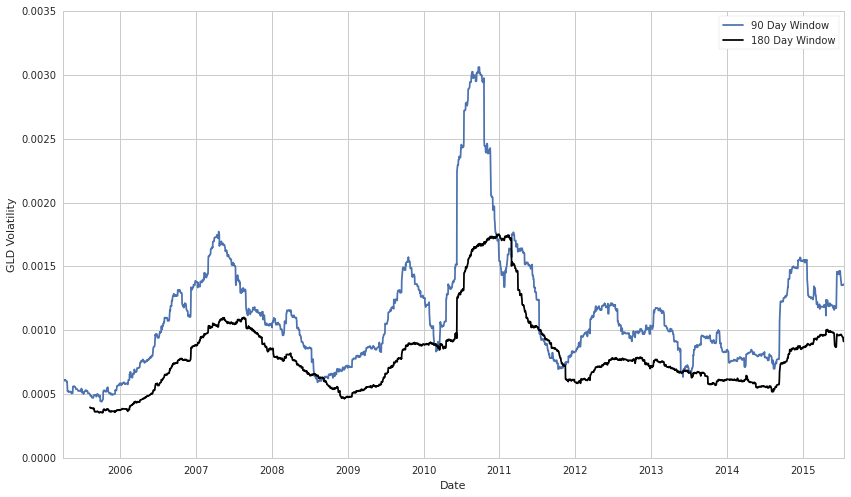

In [26]:
# Let's plot the volatilities for GLD
pyplot.plot(dates_gld,gld_vol_90,label='90 Day Window')
pyplot.plot(dates_gld,gld_vol_180,c='black',label='180 Day Window')
pyplot.xlabel('Date')
pyplot.ylabel('GLD Volatility')
pyplot.legend()
pyplot.show()

It's interesting that the volatility in GLD seems to be quasi-cyclical. Now we'll overlay GLD and Fed Sentiment for each of the windows to look for patterns:

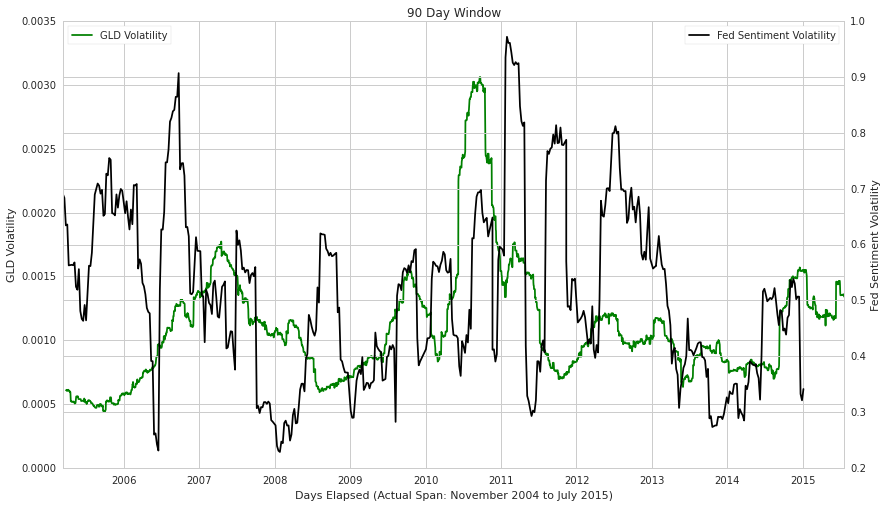

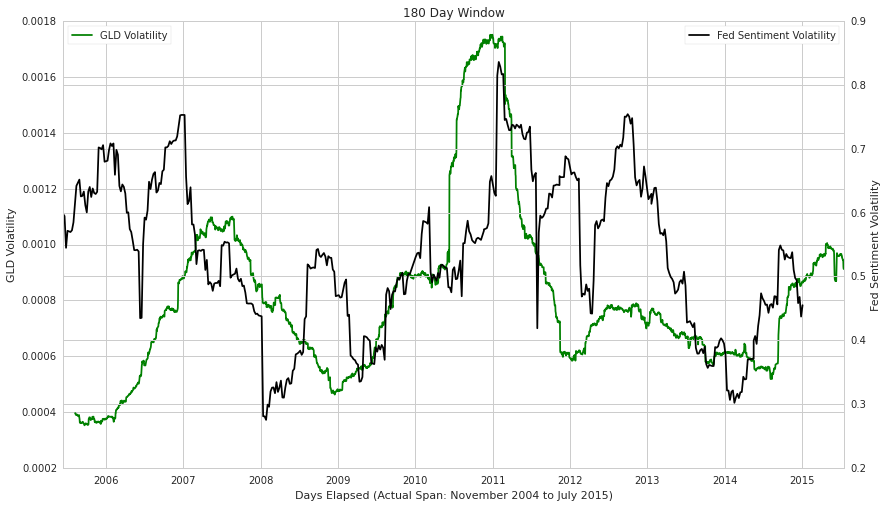

In [52]:
fig, ax1 = pyplot.subplots()
ax1.plot(dates_gld,gld_vol_90, c='green',label='GLD Volatility')
pyplot.xlabel('Days Elapsed (Actual Span: November 2004 to July 2015)')
pyplot.ylabel('GLD Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_gld_prattle, gld_prattle_vol_90, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('90 Day Window')
pyplot.legend(loc=1)

pyplot.show()

fig, ax1 = pyplot.subplots()
ax1.plot(dates_gld,gld_vol_180, c='green',label='GLD Volatility')
pyplot.xlabel('Days Elapsed (Actual Span: November 2004 to July 2015)')
pyplot.ylabel('GLD Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_gld_prattle, gld_prattle_vol_180, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('180 Day Window')
pyplot.legend(loc=1)

pyplot.show()

While we can see a few movements that correspond, most do not correspond at all. It doesn't look like there's anything in the vein of a reliable linear relationship here, even if we were to adjust for some lag between the time-series.

## TLT

Finally, we look at **TLT**, which tracks 20+ year treasury bonds. TLT stores about $6bn in assets. TLT started trading on `2002-06-24`.

In [28]:
# grab the TLT dataset and relevant prattle data.
dates_tlt, prices_tlt = get_data('TLT', '2002-06-24')
dates_tlt_prattle, scores_tlt_prattle = get_prattle('2002-06-24')

In [29]:
# Fed sentiment volatility for the relevant time period
tlt_prattle_vol_90 = roll_volatility(scores_tlt_prattle,90)
tlt_prattle_vol_180 = roll_volatility(scores_tlt_prattle,180)

In [30]:
# TLT volatility for the relevant time period
tlt_vol_90 = etf_rolling_volatility('TLT',90,dates_tlt,'2002-06-24')
tlt_vol_180 = etf_rolling_volatility('TLT',180,dates_tlt,'2002-06-24')

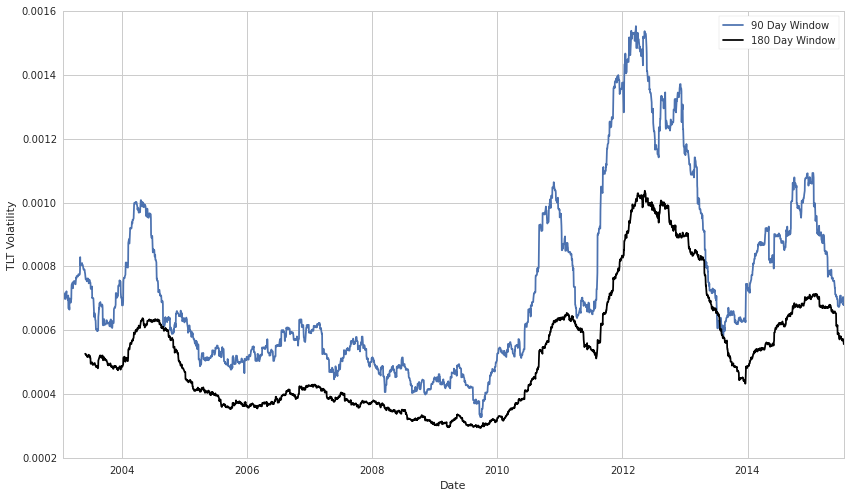

In [31]:
# Let's plot the volatilities for TLT
pyplot.plot(dates_tlt,tlt_vol_90,label='90 Day Window')
pyplot.plot(dates_tlt,tlt_vol_180,c='black',label='180 Day Window')
pyplot.xlabel('Date')
pyplot.ylabel('TLT Volatility')
pyplot.legend()
pyplot.show()

Now we'll overlay this with the Fed sentiment volatility data to look for patterns:

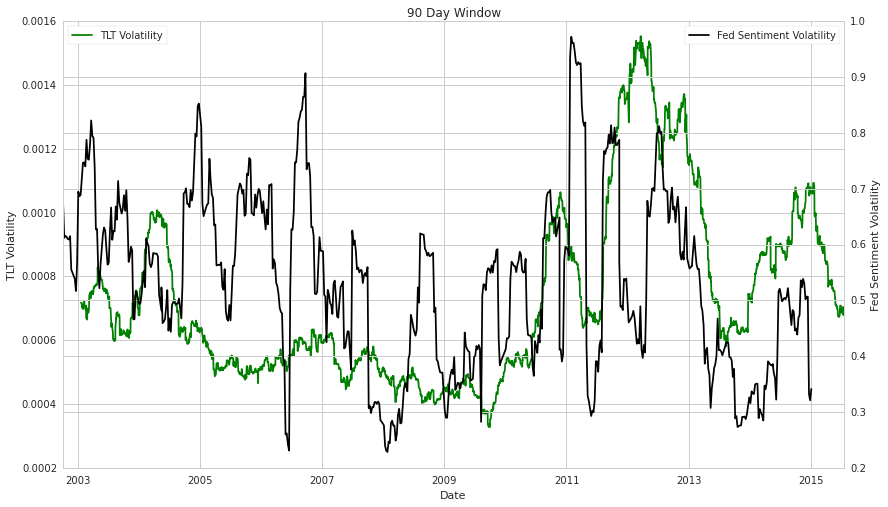

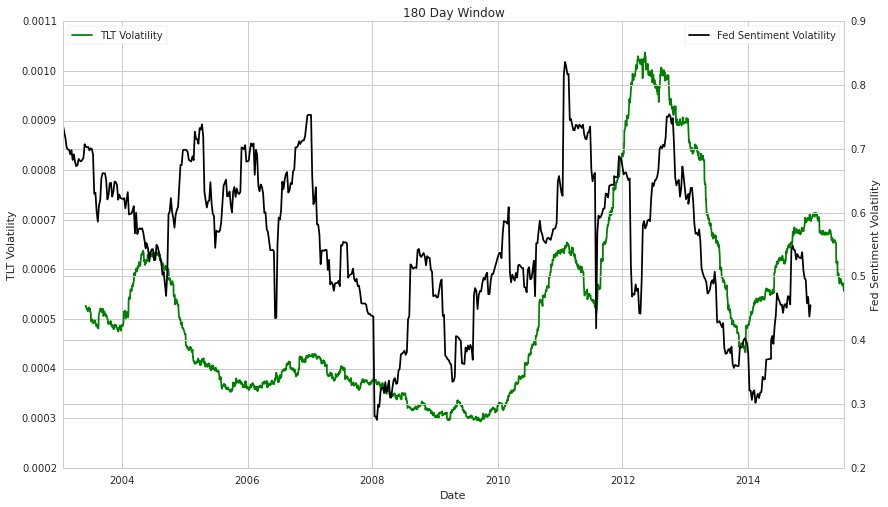

In [32]:
fig, ax1 = pyplot.subplots()
ax1.plot(dates_tlt,tlt_vol_90, c='green',label='TLT Volatility')
pyplot.xlabel('Date')
pyplot.ylabel('TLT Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_tlt_prattle, tlt_prattle_vol_90, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('90 Day Window')
pyplot.legend(loc=1)

pyplot.show()

fig, ax1 = pyplot.subplots()
ax1.plot(dates_tlt,tlt_vol_180, c='green',label='TLT Volatility')
pyplot.xlabel('Date')
pyplot.ylabel('TLT Volatility')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(dates_tlt_prattle, tlt_prattle_vol_180, c='black', label='Fed Sentiment Volatility')
pyplot.ylabel('Fed Sentiment Volatility')
pyplot.title('180 Day Window')
pyplot.legend(loc=1)

pyplot.show()

In very broad strokes, there appears to be something of a rough correspondence here. We'll try a Spearman correlation.

In [42]:
tlt_vol_90_weekly = tlt_vol_90[::5]
dates_tlt_weekly = dates_tlt[::5]
tlt_vol_180_weekly = tlt_vol_180[::5]

In [39]:
compare_tlt_90 = tlt_vol_90_weekly[:637]
compare_tlt_180 = tlt_vol_180_weekly[:637]

print scipy.stats.spearmanr(compare_tlt_90,fed_vol_2002_90)
print scipy.stats.spearmanr(compare_tlt_180,fed_vol_2002_180)
# printouts are in form (correlation coefficient, p-value)

(0.25131230884553685, 1.2435671653848182e-10)
(0.40594701329899774, 1.1433046203306307e-26)


As expected, we're seeing significant but weak-ish correlations. It's stronger for 180 days, presumably because this data is more smoothed. This observation is also in line with our observation in the [previous notebook](https://www.quantopian.com/posts/does-federal-reserve-sentiment-predict-prices-of-macro-tracking-etfs), in which we found that there appeared to be a weak correlation between Fed Sentiment and TLT.

However, looking at the plots, we notice that the signals do appear to be slightly offset. We'll use a function to find the offset between the time-series that maximizes correlation.

In [40]:
def find_offset(ts1,ts2,window):
    """ Finds the offset between two equal-length timeseries that maximizies correlation. 
        Window is # of days by which we want to left- or right-shift.
        N.B. You'll have to adjust the function for negative correlations."""
    l = len(ts1)
    if l!=len(ts2):
        raise Exception("Error! Timeseries lengths not equal!")
    max_i_spearman = -1000
    max_spearman = -1000
    spear_offsets = []
    
    # we try all possible offsets from -window to +window.
    # we record the spearman correlation for each offset.
    for i in range(window,0,-1):
        series1 = ts1[i:]
        series2 = ts2[:l-i]
        # spearmanr is a correlation test
        spear = scipy.stats.spearmanr(series1,series2)[0]
        spear_offsets.append(spear)
        
        if spear > max_spearman:
            # update best correlation
            max_spearman = spear
            max_i_spearman = -i

    for i in range(0,window):
        series1 = ts1[:l-i]
        series2 = ts2[i:]
        spear = scipy.stats.spearmanr(series1,series2)[0]
        spear_offsets.append(spear)
        if spear > max_spearman:
            max_spearman = spear
            max_i_spearman = i

    print "Max Spearman:", max_spearman, " At offset: ", max_i_spearman
    pyplot.plot(range(-window,window),spear_offsets, c='green', label='Spearman Correlation')
    pyplot.xlabel('Offset Size (Number of Business Days)')
    pyplot.ylabel('Spearman Correlation')
    pyplot.legend(loc=3)
    pyplot.show()

TLT 90 Day
Max Spearman: 0.26267469242  At offset:  4


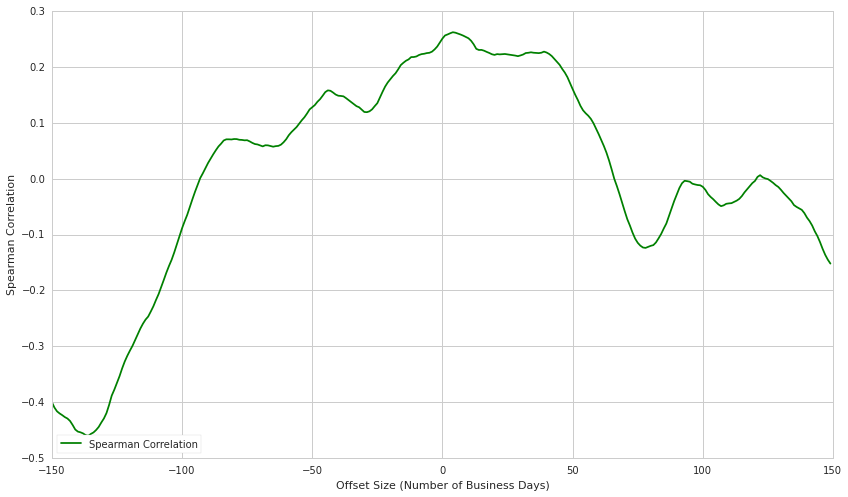

TLT 180 Day
Max Spearman: 0.376286760547  At offset:  1


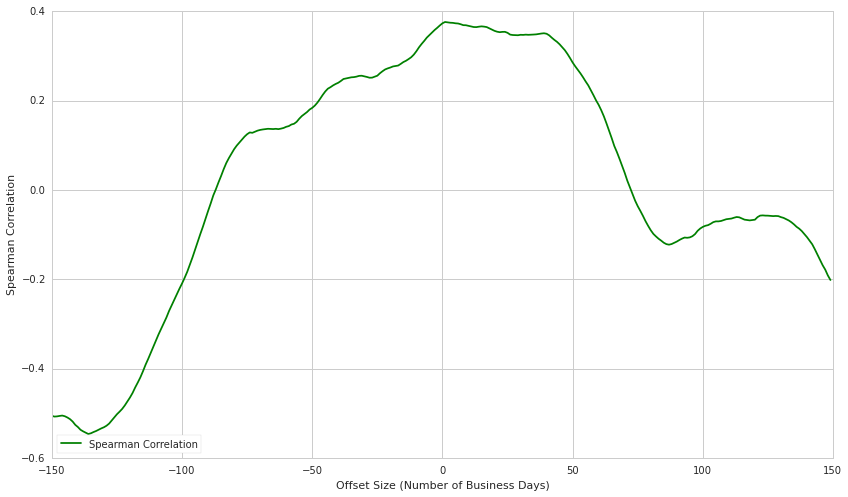

In [41]:
print "TLT 90 Day"
find_offset(compare_tlt_90,fed_vol_2002_90,150)
print "TLT 180 Day"
find_offset(compare_tlt_90,fed_vol_2002_180,150)

This indicates that the correlation values we got are (almost) the optimal correlations. It might be worthwhile to also run this function on SPY and GLD.

### Concluding Remarks

Our findings indicate weak correlations, generally commensurate with those of the [previous notebook](https://www.quantopian.com/posts/does-federal-reserve-sentiment-predict-prices-of-macro-tracking-etfs).  Especially given that there appears to be some small time lag between the two time-series, it may be possible to transform volatility in Fed sentiment into an alpha-generating signal that predicts volatility in various macro-tracking ETFs. But much more work has to be done before we can arrive at that sort of conclusion.

### More About Prattle

> From the smallest companies to the largest banks, the market is always talking. Prattle decodes this chatter, producing quantitative, real-time, tradable signals from noise. Prattle’s core product, the Fed Index, is created using language processing programs in concert with domain expertise to comprehensively and quantitatively evaluate the economic impact of the central bank’s language. Along with the Federal Reserve, Prattle evaluates 18 central banks overseeing over 90 percent of global GDP, providing financial professionals with actionable, easily integratable data on the market’s biggest movers.

Please reach out to info@prattle.co if you have any questions or want access to their data.